In [1]:
import glob
import os
import re
import pickle

import datatable as dt
import numpy as np
import pandas as pd

from datetime import datetime

import tensorflow as tf
from tensorflow.keras import models, layers, Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if 1 == len(physical_devices):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
with open('embeddings_100.pkl', 'rb') as file:
    weights = pickle.load(file)
word2idx = {}
with open('word2idx.pkl', 'rb') as file:
    word2idx = pickle.load(file)

In [8]:
def create_data(file_path, files_extension, data_percent):
    X1, X2, Y = [], [], []
    max = 0
    
    columns_to_drop = ["C0", "puuid", "bigger_region", "region", "tier", "champion_rarity", "champion_tier"]
    
    print('Creating data:')
    files = glob.glob(file_path + '/*.' + files_extension)
    files = files[:len(files)*data_percent//100]
    
    for file in tqdm(files):
        df = dt.fread(file).to_pandas()
        df.drop(columns = columns_to_drop, axis=1, inplace=True)
        df.replace('', 'null', inplace=True)
        
        if pd.unique(df.placement).shape[0] != 8:
            continue
    
        teams = []
        for place in range(1, 9): 
            team = df.where(df["placement"] == place).dropna()
            team.drop(columns=["placement"], inplace=True)
            team = team.apply(lambda row: ' '.join(row.fillna('').astype(str)), axis=1)
            
            team_word = ' '.join(team).split()
            team_vec = [weights[word2idx[word]-1] if word != 'null' 
                        else np.zeros(100, dtype=np.float32) for word in team_word ]
            team_vec = np.array(team_vec, dtype=np.float32)
            # team_vec = list(team_vec)
            # max = team_vec.shape[0] if team_vec.shape[0] > max else max
            teams.append(team_vec)
    
        for team_1 in range(8): 
            for team_2 in range(8):
                if team_1 == team_2:
                    continue
                X1.append(teams[team_1])
                X2.append(teams[team_2])
                if team_1 < team_2:
                    Y.append(1)
                else:
                    Y.append(0)
                    
    # print("Aligning data:")
    # for i in tqdm(range(len(X1))):
    #     to_add = max - X1[i].shape[0]
    #     aaa = np.zeros((to_add, 100), dtype=np.float32)
    #     X1[i] = np.vstack((X1[i], aaa))

    #     to_add = max - X2[i].shape[0]
    #     aaa = np.zeros((to_add, 100))
    #     X2[i] = np.vstack((X2[i], aaa))
        
    print("Converting lists to numpy arrays:")
    # X1, X2, Y = np.array(X1), np.array(X2), np.array(Y)

    print("Success")
    return X1, X2, Y


In [5]:
file_path = '../data_scraping/04.04.2024'
files_extension = 'csv'
data_percent = 10
X1, X2, Y = create_data(file_path, files_extension, data_percent)

Creating data:


100%|████████████████████████████████████████████████████████████████████████████████| 841/841 [00:36<00:00, 23.03it/s]

Converting lists to numpy arrays:
Success


In [6]:
# Base Network - LSTM
base_network = models.Sequential(name='Base_Network_LSTM')

base_network.add(Input(shape=(None, 100)))

base_network.add(layers.LSTM(128, return_sequences=True, name='LSTM_1'))
base_network.add(layers.LSTM(128, name='LSTM_2'))
base_network.add(layers.BatchNormalization())

base_network.add(layers.Dense(128, activation='relu'))

base_network.summary()

# Siamese Network
input_a = Input(shape=(None, 100), name='Team 1')
input_b = Input(shape=(None, 100), name='Team 2')

processed_a = base_network(input_a)
processed_b = base_network(input_b)

concat = layers.Concatenate(name='Concatenate')([processed_a, processed_b])

output = layers.Dense(1, activation='sigmoid', name='Output')(concat)

model_siamese = models.Model(inputs=[input_a, input_b], outputs=output, name='Siamese_Network')

model_siamese.compile(loss='mean_squared_error', optimizer='adamax', metrics=["accuracy", "mse"])

model_siamese.summary()


Model: "Base_Network_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, None, 128)         117248    
                                                                 
 LSTM_2 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
Total params: 265,856
Trainable params: 265,600
Non-trainable params: 256
_________________________________________________________________
Model: "Siamese_Network"
__________________________________________________________________________________

In [7]:
X1 = pad_sequences(X1, dtype='float32', padding='post', value=0.0)
X2 = pad_sequences(X2, dtype='float32', padding='post', value=0.0)
Y = np.array(Y, dtype='float32')

In [8]:
X1.shape, X2.shape, Y.shape

((46984, 91, 100), (46984, 91, 100), (46984,))

In [9]:
data_cut = X1.shape[0]
valid_data = int(0.1 * data_cut)
train_data = data_cut - valid_data

In [10]:
valid_X1 = X1[train_data:data_cut]
valid_X2 = X2[train_data:data_cut]
valid_Y = Y[train_data:data_cut]

X1 = X1[:train_data]
X2 = X2[:train_data]
Y = Y[:train_data]

In [11]:
print("valid: ",valid_X1.shape, valid_X2.shape, valid_Y.shape)
print("test: ",X1.shape, X2.shape, Y.shape)


valid:  (4698, 91, 100) (4698, 91, 100) (4698,)
test:  (42286, 91, 100) (42286, 91, 100) (42286,)


In [12]:
epochs = 100
time = datetime.now().strftime('%Y-%m-%d_%H%M%S')
checkpoint_path = f'cpLSTM/{time}/{epochs}.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0)

In [13]:
model_siamese.fit([X1, X2], Y, batch_size=250, epochs=epochs, validation_split=0.15, callbacks=[checkpoint])

Epoch 1/100
144/144 [==============================] - 24s 94ms/step - loss: 0.1871 - accuracy: 0.7136 - mse: 0.1871 - val_loss: 0.2037 - val_accuracy: 0.7332 - val_mse: 0.2037
Epoch 2/100
144/144 [==============================] - 12s 80ms/step - loss: 0.1499 - accuracy: 0.7809 - mse: 0.1499 - val_loss: 0.1577 - val_accuracy: 0.7701 - val_mse: 0.1577
Epoch 3/100
144/144 [==============================] - 11s 78ms/step - loss: 0.1372 - accuracy: 0.8026 - mse: 0.1372 - val_loss: 0.1559 - val_accuracy: 0.7738 - val_mse: 0.1559
Epoch 4/100
144/144 [==============================] - 12s 80ms/step - loss: 0.1316 - accuracy: 0.8130 - mse: 0.1316 - val_loss: 0.1570 - val_accuracy: 0.7706 - val_mse: 0.1570
Epoch 5/100
144/144 [==============================] - 11s 78ms/step - loss: 0.1277 - accuracy: 0.8187 - mse: 0.1277 - val_loss: 0.1535 - val_accuracy: 0.7742 - val_mse: 0.1535
Epoch 6/100
144/144 [==============================] - 11s 77ms/step - loss: 0.1232 - accuracy: 0.8252 - mse: 0.123

In [17]:
results = model_siamese.evaluate([valid_X1, valid_X2], valid_Y, batch_size=1)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
predictions = model_siamese.predict([valid_X1, valid_X2])
predicted_classes = (predictions > 0.5).astype(int)

In [ ]:
cm = confusion_matrix(valid_Y, predicted_classes)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.show()

In [10]:
with open('embeddings_100.pkl', 'rb') as file:
    weights = pickle.load(file)
word2idx = {}
with open('word2idx.pkl', 'rb') as file:
    word2idx = pickle.load(file)

In [11]:
file_path = '../data_scraping/04.04.2024'
files_extension = 'csv'
data_percent = 10
X1, X2, Y = create_data(file_path, files_extension, data_percent)

Creating data:


100%|████████████████████████████████████████████████████████████████████████████████| 841/841 [00:27<00:00, 30.92it/s]

Converting lists to numpy arrays:
Success


In [12]:
X1 = pad_sequences(X1, dtype='float32', padding='post', value=0.0)
X2 = pad_sequences(X2, dtype='float32', padding='post', value=0.0)
Y = np.array(Y, dtype='float32')

data_cut = X1.shape[0]
valid_data = int(0.1 * data_cut)
train_data = data_cut - valid_data

valid_X1 = X1[train_data:data_cut]
valid_X2 = X2[train_data:data_cut]
valid_Y = Y[train_data:data_cut]

X1 = X1[:train_data]
X2 = X2[:train_data]
Y = Y[:train_data]

In [13]:
# Ścieżka do zapisanego modelu
checkpoint_path = f'cpLSTM/2024-06-12_180454/100.h5'

# Wczytywanie modelu
model_siamese = load_model(checkpoint_path)

In [14]:
results = model_siamese.evaluate([valid_X1, valid_X2], valid_Y, batch_size=320)
# print(f"Loss: {results[0]}, Accuracy: {results[1]}, MSE: {results[2]}")

4698/4698 [==============================] - 88s 18ms/step - loss: 0.2161 - accuracy: 0.7652 - mse: 0.2161
Loss: 0.2161106914281845, Accuracy: 0.7652192711830139, MSE: 0.2161106914281845


In [15]:
predictions = model_siamese.predict([valid_X1, valid_X2])
predicted_classes = (predictions > 0.5).astype(int)

147/147 [==============================] - 5s 23ms/step


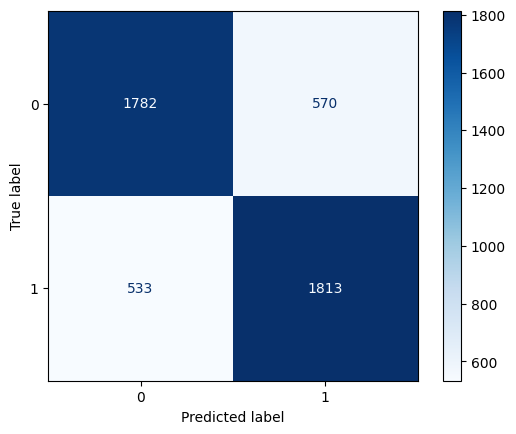

In [16]:
cm = confusion_matrix(valid_Y, predicted_classes)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.show()